In [1]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import (
    roc_curve,
    auc, accuracy_score,
    precision_score,
    recall_score,
    precision_recall_curve,
    average_precision_score,
)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel

from confusion_matrix import plot_confusion_matrix


In [2]:
# Plots stuff
from pylab import rcParams

rcParams['figure.figsize'] = 12, 8
%matplotlib inline

sns.set()

plt.rcParams['figure.dpi'] = 100

In [3]:
random_seed = 2512
random_state = np.random.RandomState(random_seed)

# Loading and preparing data

In [4]:
OUTCOMES = ['Significant_bleeding_outcome', 'Stroke_outcome', 'Death_and_renal_failure', 'Death_inhosp',]
AMBIGUOUS_COLUMNS = ['PRU_more208', 'PRU_less95']
STRING_COLUMNS = ['AF_type', 'Stent_type', 'CYP4F2', 'P2Y12'] # These columns should be encoded with LabelEncoder
MAX_PRU = 208 # Maximum and minimum PRU borders, lower and higher is an unsafe zone
MIN_PRU = 95
UNNEEDED_COLUMNS = [
    'Agr_Platelets_Cat',
    'Residual_more230',
    'Residual_reactivity_less85',
    'CrusadeScore_bleeding',
    'Acatalepsia',
    'Gastric',
]
NUMERIC_COLUMNS = [
    'Age',
    'GFR',
    'PRU',
    'Xarelto_C_blood',
    'inhibition',
    'CRUSADE',
    'SYNTAX_score',
    'Hb',
    'CHA2DS2VASC',
    'Hasbled',
    'Agr_Platelets_base',
]

In [5]:
df = pd.read_csv('xarelto_fg.csv', header=0, index_col=0)[:103]

SINGLE_VALUE_COLUMNS = [col for col in df.columns if len(df[col].unique()) == 1]

df = df.drop([*UNNEEDED_COLUMNS, *AMBIGUOUS_COLUMNS, *SINGLE_VALUE_COLUMNS], axis=1)

for outcome in OUTCOMES:
    df[outcome] = df[outcome].replace(' ', 0).astype(float)

for numeric_col in NUMERIC_COLUMNS:
    df[numeric_col] = df[numeric_col].astype(float)

for category_col in STRING_COLUMNS:
    encoder = LabelEncoder()
    df[category_col + '_encoded'] = encoder.fit_transform(df[category_col])



In [6]:
def _process_row_outcomes(row):
    possible_outcomes = [outcome for outcome in OUTCOMES if row[outcome]]
    if not possible_outcomes:
        return 'Survived'
    elif len(possible_outcomes) == 1:
        return possible_outcomes[0]
    elif (
        'Significant_bleeding_outcome' in possible_outcomes and
        'Death_and_renal_failure' in possible_outcomes
    ):
        return 'Death_renal_failure_bleeding' # Maybe later we'll have enough data points to consider this outcome
    elif (
        'Significant_bleeding_outcome' in possible_outcomes and
        'Death_inhosp' in possible_outcomes
    ):
        return 'Death_in_hospital_bleeding' # Maybe later we'll have enough data points to consider this outcome
    else:
        return 'Death_renal_failure_inhosp'


def process_row_outcomes(row):
    outcome = _process_row_outcomes(row)
    if 'Death' in outcome: # TODO Discuss
        return 'Death'
    elif (
        outcome == 'Significant_bleeding_outcome' or 
        outcome == 'Stroke_outcome'
    ):
#         return 'Bleeding_or_stroke'
        return 'Survived'
    return outcome




df['Outcome'] = df.apply(
    process_row_outcomes,
    axis = 1
)


# Initial analysis

In [7]:
SINGLE_VALUE_COLUMNS

['Thrombosysis', 'CYP2C19_3_G636A']

In [8]:
df.head()

,Sex,Age,Xarelto_C_blood,Agr_Platelets_base,inhibition,PRU,C_rivar_137,STEMI,NSTEMI,Unstableangina,...,CYP3A4_2242480,PON1,IGTB3,P2Y12,PEAR1_rs41273215,AF_type_encoded,Stent_type_encoded,CYP4F2_encoded,P2Y12_encoded,Outcome
Number,,,,,,,,,,,,,,,,,,,,,
1,1,81.0,204.0,195.0,48.0,102.0,1,0,1,0,...,1,2,1,1,1,2,2,2,1,Death
2,1,88.0,134.0,196.0,28.0,141.0,0,0,0,1,...,1,2,2,1,1,2,0,1,1,Death
3,1,81.0,242.0,211.0,13.0,183.0,1,0,1,0,...,1,2,1,2,2,2,3,2,2,Death
4,0,73.0,57.0,163.0,12.0,144.0,0,0,1,0,...,1,2,2,2,2,1,3,2,2,Survived
5,0,61.0,37.0,182.0,11.0,162.0,0,0,0,1,...,1,2,1,2,1,1,3,2,2,Survived


In [9]:
df.columns

Index(['Sex', 'Age', 'Xarelto_C_blood', 'Agr_Platelets_base', 'inhibition',
       'PRU', 'C_rivar_137', 'STEMI', 'NSTEMI', 'Unstableangina', 'PCI',
       'AF_type', 'Death_inhosp', 'Obesity', 'Alcohol', 'Smoking',
       'Cardiosclerosis', 'Previous_PCI', 'PreviousCABG', 'Access',
       'Stent_type', 'Stent_quant', 'HighriskSYNTAX', 'Grace_score_risk',
       'SYNTAX_score', 'CRUSADE', 'Killip', 'Heart_Stop', 'Hypertension',
       'HeartFailure_before', 'Stroke', 'Previous_thromboses', 'Diabetes',
       'PAD', 'COPD', 'Onco', 'Previous_bleeding', 'Anaemialessthan100',
       'Plateletslessthan100', 'Highplateletsondischarge',
       'Death_and_renal_failure', 'RenalFailure', 'HeartFailure', 'HasBLED39',
       'DAPT_TAPT', 'Hb', 'GFR', 'CHA2DS2VASC', 'Hasbled', 'duration_months',
       'Rivaroxaban_dose', 'Significant_bleeding_outcome', 'Stroke_outcome',
       'CYP3A4_22', 'ABCB1_С3435Т', 'ABCB1_СТrs4148738', 'CYP2C19_2_G681A',
       'CYP2C19_17_C806T', 'CYP3A5_3_A6986G', 'ABCB

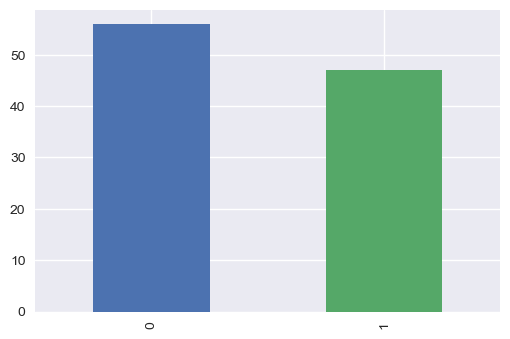

In [10]:
df.Sex.value_counts().plot(kind='bar')

Text(0.5,0,'Age')

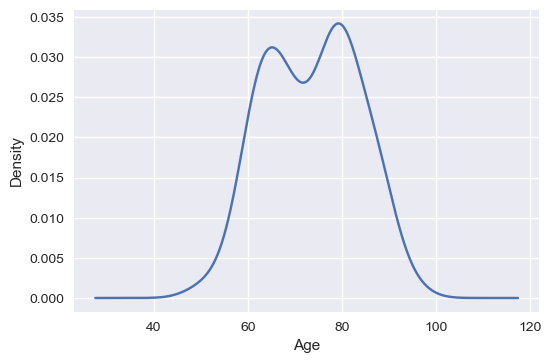

In [11]:
fig, ax = plt.subplots()
df.Age.plot(kind='kde')
ax.set_xlabel('Age')

Text(0.5,0,'Xarelto_C_blood')

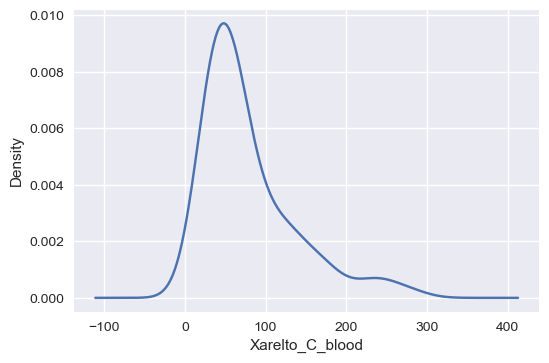

In [12]:
fig, ax = plt.subplots()
df.Xarelto_C_blood.plot(kind='kde')
ax.set_xlabel('Xarelto_C_blood')

Text(0.5,0,'Agr_Platelets_base')

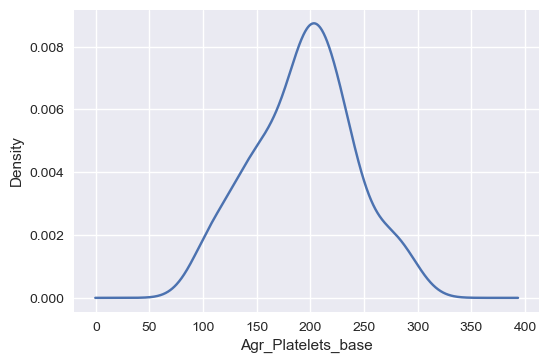

In [13]:
fig, ax = plt.subplots()
df.Agr_Platelets_base.plot(kind='kde')
ax.set_xlabel('Agr_Platelets_base')

Text(0.5,0,'GFR')

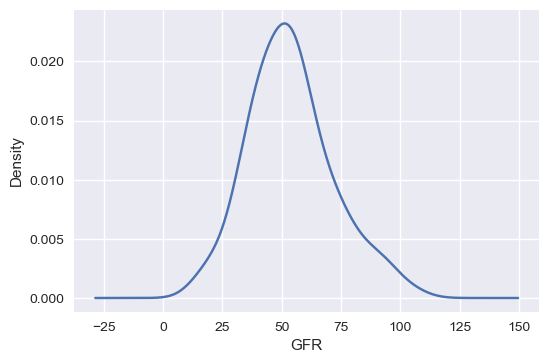

In [14]:
fig, ax = plt.subplots()
df.GFR.plot(kind='kde')
ax.set_xlabel('GFR')

# Task number 1

Concentration prediction

Target columns -> `'Significant_bleeding_outcome', 'Stroke_outcome', 'Death_and_renal_failure', 'Death_inhosp'`

## Analysing and converting boolean outcome variables into single categorical ones

In [15]:
df[[col for col in df.columns if col in OUTCOMES]].describe()

,Death_inhosp,Death_and_renal_failure,Significant_bleeding_outcome,Stroke_outcome
count,103.000000,103.000000,103.000000,103.000000
mean,0.029126,0.320388,0.106796,0.019417
std,0.168983,0.468908,0.310364,0.138662
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


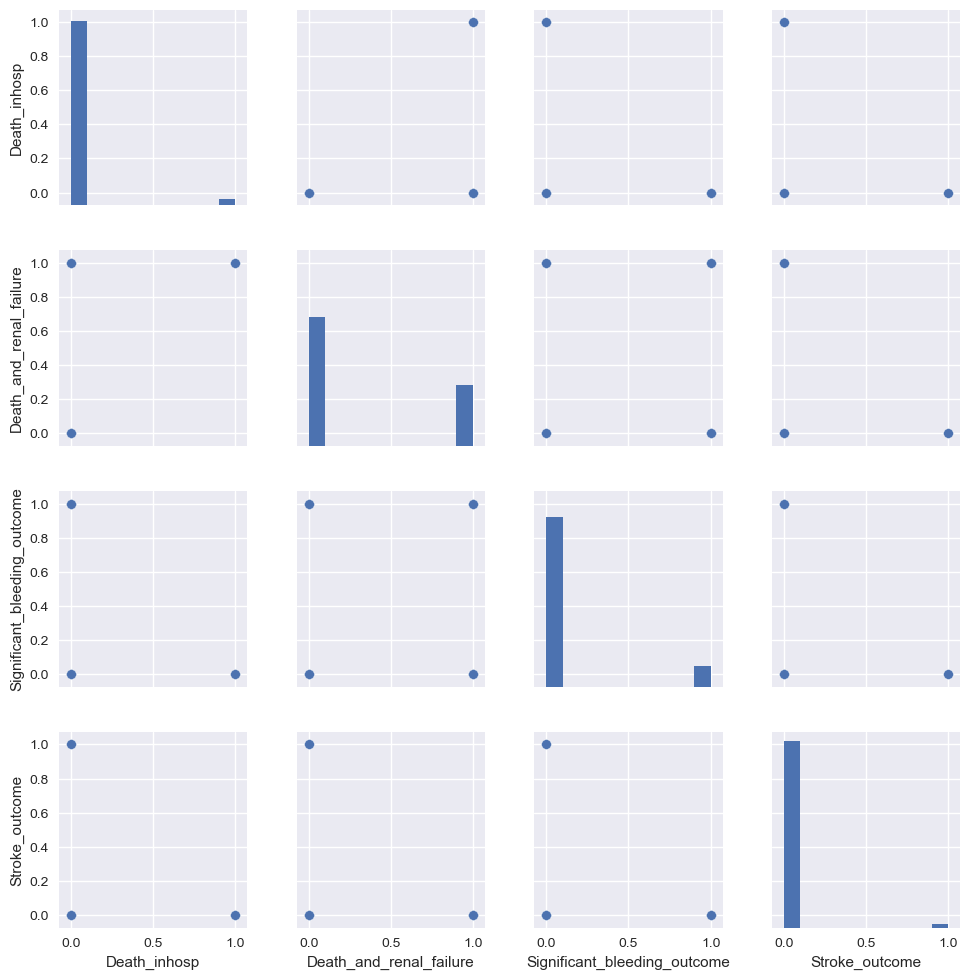

In [16]:
sns.pairplot(df[[col for col in df.columns if col in OUTCOMES]].astype('int'))

# Using LOOCV to evaluate models 

In [17]:
df2 = df[
    [
        col for col in df.columns
        if not col in [
            *OUTCOMES,
            *STRING_COLUMNS,
        ]
    ]
]
df2 = df2.replace(' ', 0)


encoder = LabelEncoder()
df2['Outcome_encoded'] = encoder.fit_transform(df2.Outcome)
X = df2[[col for col in df2.columns if not col.startswith('Outcome')]]
Y = df2['Outcome_encoded']
CLASS_NAMES = encoder.classes_

### 1. LOOCV

In [18]:
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LogisticRegression

def evaluate_with_conf_matrix_loocv(model, X, Y, model_name):
    ##### LOOCV MODEL EVALUATION AND CONFUSION MATRIX PLOT
    loo = LeaveOneOut()
    loo.get_n_splits(X)
    predictions = []


    for train, test in loo.split(X):
        predictions.append(model.fit(X.iloc[train], Y.iloc[train]).predict(X.iloc[test])[0])

    predictions = pd.Series(predictions)

    with sns.axes_style("darkgrid", {"axes.grid": False}):
        plot_confusion_matrix(
            Y,
            predictions,
            classes=CLASS_NAMES,
            normalize=False,
            title=f'Confusion matrix for {model_name}'
        )

        
def plot_important_features(X, coefficients, name, normalize=True):
    ##### TOP MOST IMPORTANT FEATURES PLOT

    N_to_print = min(20, X.shape[1]) # Plot up to 20 most important features
    y_pos = range(N_to_print)
    fig, ax = plt.subplots()
    plt.figure(figsize=(10,7))

    feature_importance = coefficients.round(4)
    feature_importance = zip(X.keys(), feature_importance)
    feature_importance = np.array(sorted(
        map(
            lambda pair: pair[1] != abs(pair[1]) and ('[negative]' + pair[0], abs(pair[1])) or (pair[0], pair[1]),
            feature_importance
        ),
        key=lambda x:x[1], reverse=True))
    ax.barh(y_pos, feature_importance[:N_to_print, 1].astype('float'), align='center', color='green')
    ax.set_yticks(np.arange(N_to_print))
    ax.set_yticklabels(feature_importance[:N_to_print, 0])
    ax.invert_yaxis()
    ax.set_xlabel(f'Importance/coefficients for {name}')

    plt.show()

Confusion matrix, without normalization
[[31  2]
 [ 1 69]]


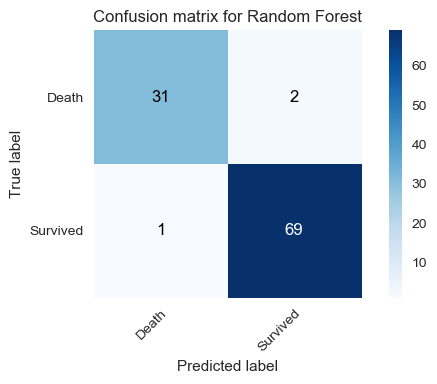

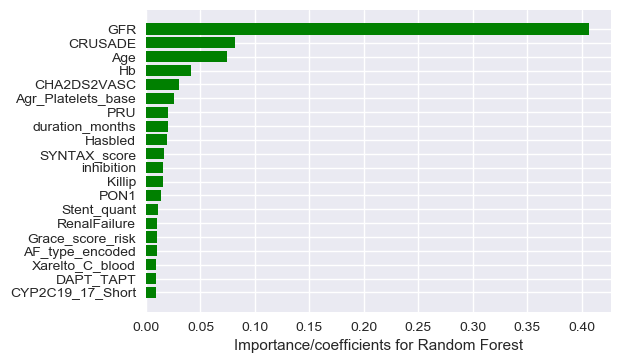

<Figure size 1000x700 with 0 Axes>

Confusion matrix, without normalization
[[31  2]
 [ 0 70]]


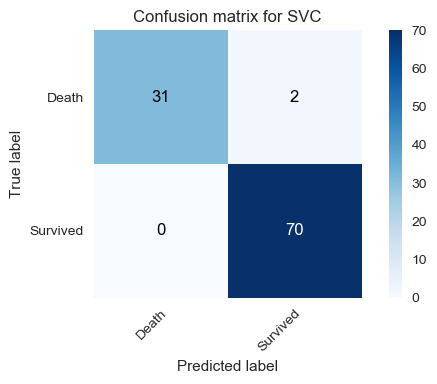

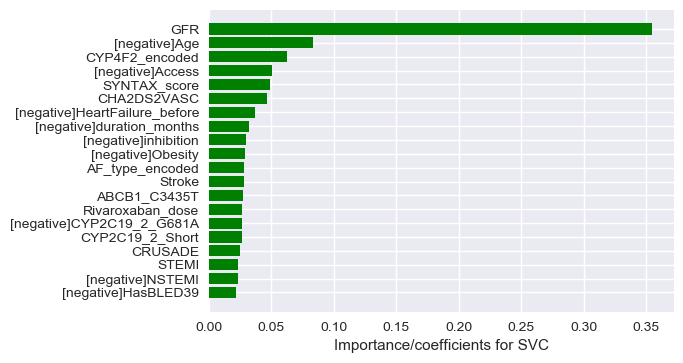

<Figure size 1000x700 with 0 Axes>

Confusion matrix, without normalization
[[33  0]
 [ 1 69]]


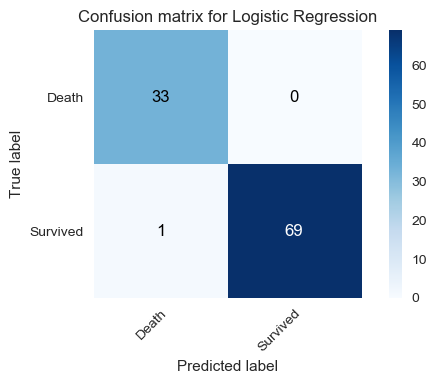

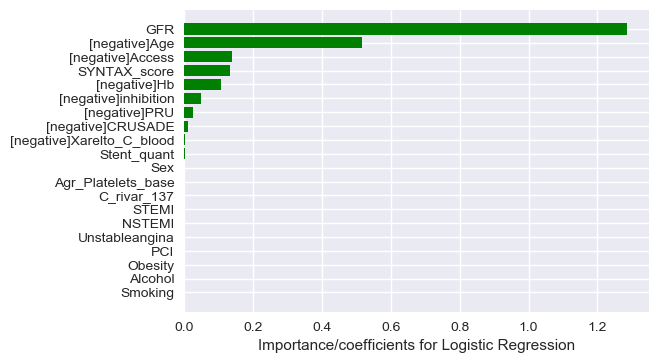

<Figure size 1000x700 with 0 Axes>

In [19]:
rf = RandomForestClassifier(n_jobs=6, n_estimators=50, random_state=random_state)
svc = SVC(kernel='linear', random_state=random_state)
log_reg = LogisticRegression(random_state=random_state, penalty='l1') # Use LASSO regularizer
for name, model in [
    ['Random Forest', rf],
    ['SVC', svc],
    ['Logistic Regression', log_reg],
]:
    evaluate_with_conf_matrix_loocv(model, X, Y, name)
    plot_important_features(X, model.coef_[0] if name != 'Random Forest' else model.feature_importances_, name)




### Removing insignificant variables

In [20]:
transforming_model = SelectFromModel(log_reg, prefit=True)
X_transformed = transforming_model.transform(X)
feature_idx = transforming_model.get_support()
feature_names = X.columns[feature_idx]
X_transformed = pd.DataFrame(X_transformed, columns=X.columns[feature_idx])


In [21]:
feature_names

Index(['Age', 'Xarelto_C_blood', 'inhibition', 'PRU', 'Access', 'Stent_quant',
       'SYNTAX_score', 'CRUSADE', 'Hb', 'GFR'],
      dtype='object')

### Testing models using only significant columns

Confusion matrix, without normalization
[[33  0]
 [ 0 70]]


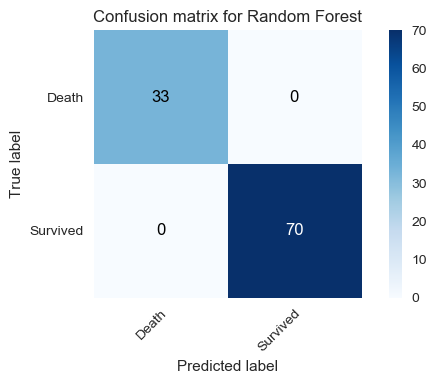

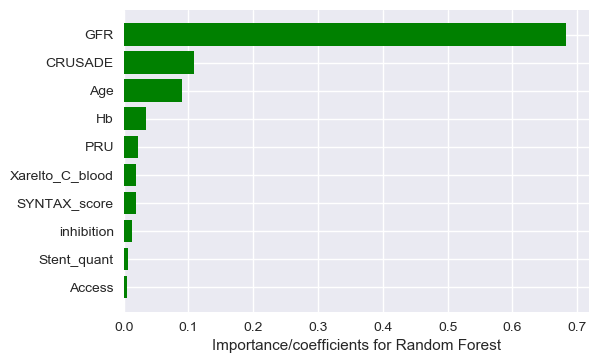

<Figure size 1000x700 with 0 Axes>

Confusion matrix, without normalization
[[33  0]
 [ 1 69]]


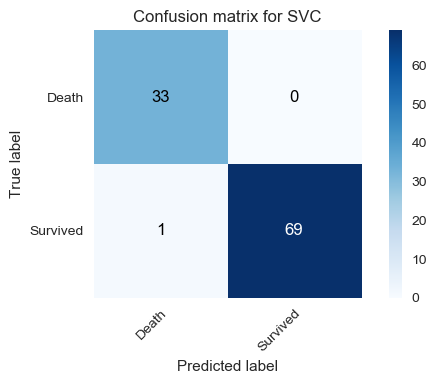

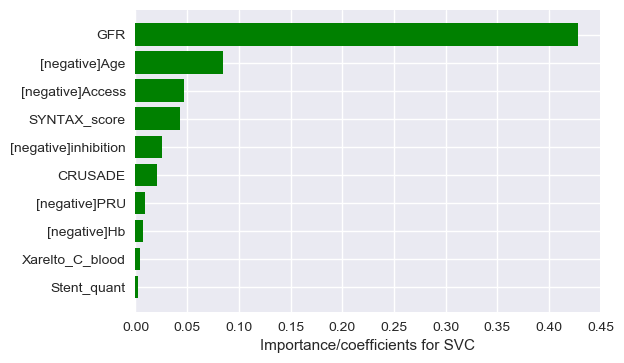

<Figure size 1000x700 with 0 Axes>

Confusion matrix, without normalization
[[33  0]
 [ 1 69]]


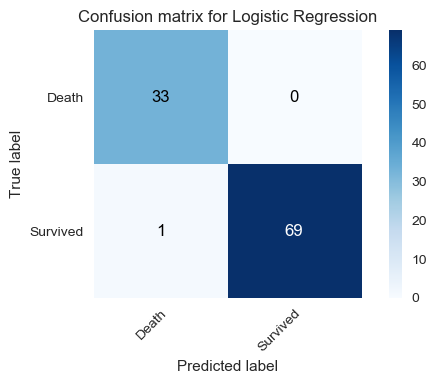

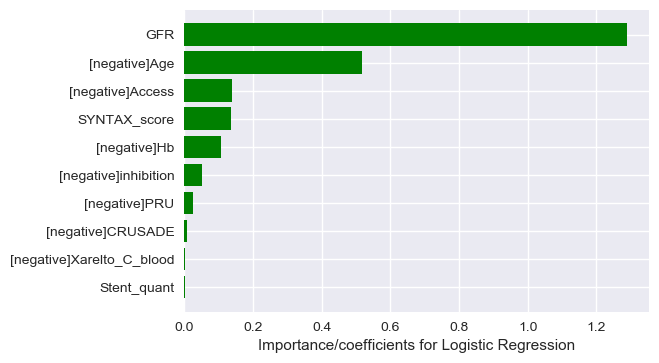

<Figure size 1000x700 with 0 Axes>

In [22]:
for name, model in [
    ['Random Forest', rf],
    ['SVC', svc],
    ['Logistic Regression', log_reg],
]:
    evaluate_with_conf_matrix_loocv(model, X_transformed, Y, name)
    plot_important_features(X_transformed, model.coef_[0] if name != 'Random Forest' else model.feature_importances_, name)



# Outcomes analysis

Text(0.5,1,'GFR grouped by outcome')

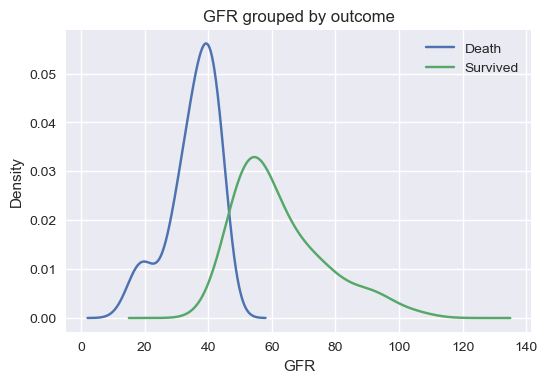

In [23]:
fig, ax = plt.subplots()
df2.groupby("Outcome").GFR.plot(kind='kde')
ax.legend(["Death", "Survived"]);
ax.set_xlabel('GFR')
ax.set_title('GFR grouped by outcome')

Text(0.5,1,'Age grouped by outcome')

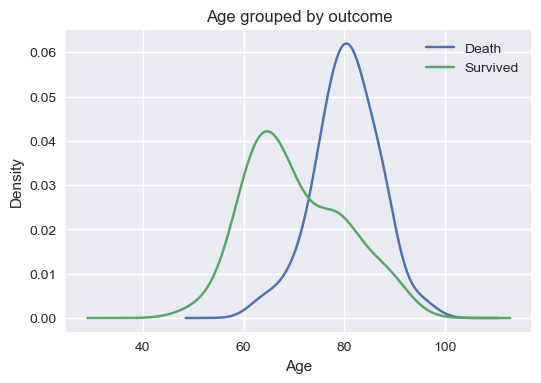

In [24]:
fig, ax = plt.subplots()
df2.groupby("Outcome").Age.plot(kind='kde')
ax.legend(["Death", "Survived"]);
ax.set_xlabel('Age')
ax.set_title('Age grouped by outcome')

Text(0.5,1,'CRUSADE grouped by outcome')

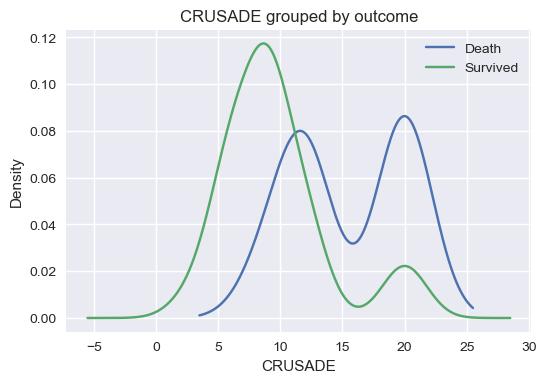

In [25]:
fig, ax = plt.subplots()
df2.groupby("Outcome").CRUSADE.plot(kind='kde')
ax.legend(["Death", "Survived"]);
ax.set_xlabel('CRUSADE')
ax.set_title('CRUSADE grouped by outcome')

Text(0.5,1,'SYNTAX_score grouped by outcome')

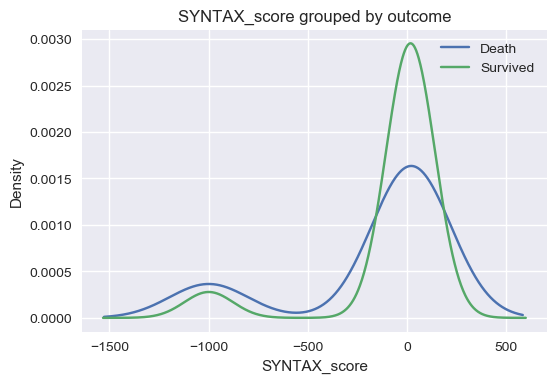

In [26]:
fig, ax = plt.subplots()
df2.groupby("Outcome").SYNTAX_score.plot(kind='kde')
ax.legend(["Death", "Survived"]);
ax.set_xlabel('SYNTAX_score')
ax.set_title('SYNTAX_score grouped by outcome')

Text(0.5,1,'PRU grouped by outcome')

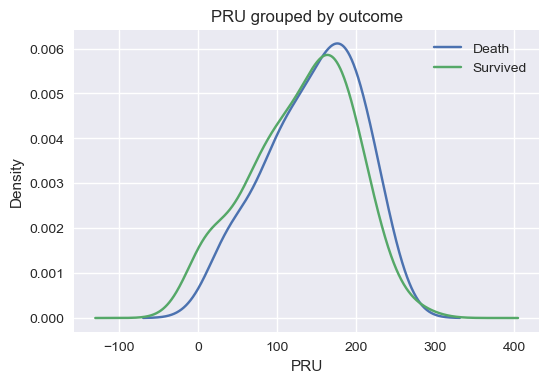

In [27]:
fig, ax = plt.subplots()
df2.groupby("Outcome").PRU.plot(kind='kde')
ax.legend(["Death", "Survived"]);
ax.set_xlabel('PRU')
ax.set_title('PRU grouped by outcome')

Text(0.5,1,'Hb grouped by outcome')

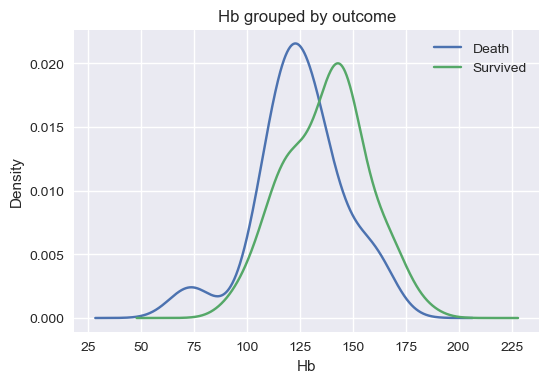

In [28]:
fig, ax = plt.subplots()
df2.groupby("Outcome").Hb.plot(kind='kde')
ax.legend(["Death", "Survived"]);
ax.set_xlabel('Hb')
ax.set_title('Hb grouped by outcome')


Text(0.5,1,'Xarelto_C_blood grouped by outcome')

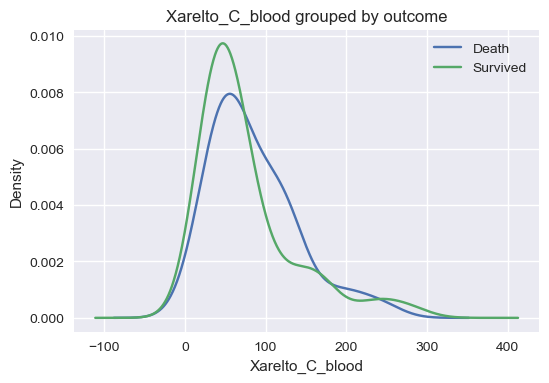

In [29]:
fig, ax = plt.subplots()
df2.groupby("Outcome").Xarelto_C_blood.plot(kind='kde')
ax.legend(["Death", "Survived"]);
ax.set_xlabel('Xarelto_C_blood')
ax.set_title('Xarelto_C_blood grouped by outcome')

# Task number 2

Concentration prediction

Target column -> `Xarelto_C_blood`

### Removing outcome columns 

In [30]:
df3 = df[
    [
        col for col in df.columns
        if not col in [
            *OUTCOMES,
            *STRING_COLUMNS,
            *['Outcome',]
        ]
    ]
]
df3 = df3.replace(' ', 0)

X_reg = df2[[col for col in df2.columns if not col == 'Xarelto_C_blood']]
Y_reg = df2.Xarelto_C_blood
